### Use case description

Developing a case where by controlling the laser power of the main laser and a secondary laser we achieve an optimal thermal response.

### Load libraries

In [1]:
import time
import pyvista as pv
from pyvirtualdisplay import Display
import vtk
from termcolor import colored
from IPython.display import HTML
import numpy as np
import pandas as pd
import taichi as ti
%matplotlib inline
import matplotlib.pyplot as plt
pv.set_plot_theme("document")

[Taichi] mode=release
[Taichi] preparing sandbox at /tmp/taichi-o928h8l_
[Taichi] version 0.7.0, llvm 10.0.0, commit 0298bca3, linux, python 3.7.7


### Load input file

In [2]:
def load_inputfile(filename='0.k'):
    nodes = []
    node_sets = {}
    elements = []
    birth_list_element = []
    birth_list_node = []

    with open(filename) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*NODE':
                first = True
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    if first:
                        node_base = int(text[0])
                        first = False
                    nodes.append([float(text[1]),float(text[2]),float(text[3])])
            if line.split()[0] == '*END':
                break  
    birth_list_node = [-1 for _ in range(len(nodes))]
    with open(filename) as f:
        line = next(f)
        while True:
            if not line.split():
                line = next(f)
                continue
            elif line.split()[0] == '*SET_NODE_LIST':
                line = next(f)
                line = next(f)
                key = int(line.split()[0])
                node_list = []
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    for text in line.split():
                        node_list.append(int(text)-node_base)
                node_sets[key] = node_list
            elif line.split()[0] == '*END':
                break
            else:
                line = next(f)
    with open(filename) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*ELEMENT_SOLID':
                first = True
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    if first:
                        element_base = int(text[0])
                        first = False
                    elements.append([int(text[2])-node_base, int(text[3])-node_base, int(text[4])-node_base, int(text[5])-node_base,
                                     int(text[6])-node_base, int(text[7])-node_base, int(text[8])-node_base, int(text[9])-node_base])
            if line.split()[0] == '*END':
                break
    birth_list_element = [-1.0]*len(elements)
    with open(filename) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*DEFINE_CURVE':
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    birth_list_element[int(float(text[1]))-element_base] = float(text[0])
            if line.split()[0] == '*END':
                break
    for element, birth_element in zip(elements, birth_list_element):
        if birth_element < 0:
            continue
        for node in element:
            if (birth_list_node[node] > birth_element or 
                                        birth_list_node[node] < 0):
                                    birth_list_node[node] = birth_element
    
    # create element surface for node ids
    element_surface = np.zeros((len(elements), 6, 4), dtype=np.int32)
    for ind, element in enumerate(elements):
        element_surface[ind, 0, :] = [element[0], element[1], element[2],element[3]]
        element_surface[ind, 1, :] = [element[4], element[5], element[6],element[7]]
        element_surface[ind, 2, :] = [element[0], element[3], element[7],element[4]]
        element_surface[ind, 3, :] = [element[1], element[2], element[6],element[5]]
        element_surface[ind, 4, :] = [element[0], element[1], element[5],element[4]]
        element_surface[ind, 5, :] = [element[3], element[2], element[6],element[7]]

    # create element surface neighbors 
    def match_surface(ind, s_ind):
        for surf_ind, surf in enumerate(element_surface[ind]):
            for s_surf in element_surface[s_ind]:
                if set(surf) == set(s_surf):
                    return surf_ind
        else:
            return -1

    element_surface_neighbor = np.ones((len(elements), 6), dtype=np.int32) * -1
    for ind, element in enumerate(elements):
        for s_ind, s_element in enumerate(elements):
            if any(node in element for node in s_element) and ind != s_ind:
                surf_ind = match_surface(ind, s_ind)
                if surf_ind != -1:
                    element_surface_neighbor[ind, surf_ind] = s_ind

    # create element surface birth
    element_surface_birth = np.zeros((len(elements), 6, 2), dtype=np.float)
    for ele_ind, element_surface_nei in enumerate(element_surface_neighbor):
        for sur_ind, neighbor_ind in enumerate(element_surface_nei):
            if neighbor_ind == -1:
                birth = birth_list_element[ele_ind]
                death = 1.0e6
            else:
                birth = min(birth_list_element[ele_ind], birth_list_element[neighbor_ind])
                death = max(birth_list_element[ele_ind], birth_list_element[neighbor_ind])
            element_surface_birth[ele_ind, sur_ind] = [birth, death]
            
    return nodes, birth_list_node, elements, birth_list_element, element_surface, element_surface_birth

def load_toolpath(filename = 'toolpath.crs', dt = 0.05):
    toolpath_raw=pd.read_table(filename, delimiter=r"\s+",header=None, names=['time','x','y','z','state'])
    toolpath=[]
    state=[]
    ctime=0.0
    ind=0
    endTime = float(toolpath_raw.tail(1)['time'])
    while(ctime<=endTime):
        while(ctime>=toolpath_raw['time'][ind+1]):
            ind=ind+1
        X=toolpath_raw['x'][ind]+(toolpath_raw['x'][ind+1]-toolpath_raw['x'][ind])*(
            ctime-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Y=toolpath_raw['y'][ind]+(toolpath_raw['y'][ind+1]-toolpath_raw['y'][ind])*(
            ctime-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Z=toolpath_raw['z'][ind]+(toolpath_raw['z'][ind+1]-toolpath_raw['z'][ind])*(
            ctime-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        toolpath.append([X,Y,Z])
        state.append(toolpath_raw['state'][ind+1])
        ctime = ctime + dt
    # add 10s time to allow it to cool down at the end
    for  _ in range(int(10.0/dt)):
        toolpath.append([X,Y,Z])
        state.append(0)
    endTime = endTime + 10.0
    return toolpath, state, endTime

def shape_fnc_element(parCoord):
    chsi = parCoord[0]
    eta = parCoord[1]
    zeta = parCoord[2]
    N =  0.125 * np.stack([(1.0 - chsi)*(1.0 - eta)*(1.0 - zeta),(1.0 + chsi)*(1.0 - eta)*(1.0 - zeta),
                           (1.0 + chsi)*(1.0 + eta)*(1.0 - zeta), (1.0 - chsi)*(1.0 + eta)*(1.0 - zeta),
                           (1.0 - chsi)*(1.0 - eta)*(1.0 + zeta), (1.0 + chsi)*(1.0 - eta)*(1.0 + zeta),
                           (1.0 + chsi)*(1.0 + eta)*(1.0 + zeta), (1.0 - chsi)*(1.0 + eta)*(1.0 + zeta)])
    return N
    
def derivate_shape_fnc_element(parCoord):
    oneMinusChsi = 1.0 - parCoord[0]
    onePlusChsi  = 1.0 + parCoord[0]
    oneMinusEta  = 1.0 - parCoord[1]
    onePlusEta   = 1.0 + parCoord[1]
    oneMinusZeta = 1.0 - parCoord[2]
    onePlusZeta  = 1.0 + parCoord[2]
    B = 0.1250 * np.array([[-oneMinusEta * oneMinusZeta, oneMinusEta * oneMinusZeta, 
                                onePlusEta * oneMinusZeta, -onePlusEta * oneMinusZeta, 
                                -oneMinusEta * onePlusZeta, oneMinusEta * onePlusZeta, 
                                onePlusEta * onePlusZeta, -onePlusEta * onePlusZeta],
                              [-oneMinusChsi * oneMinusZeta, -onePlusChsi * oneMinusZeta, 
                               onePlusChsi * oneMinusZeta, oneMinusChsi * oneMinusZeta, 
                               -oneMinusChsi * onePlusZeta, -onePlusChsi * onePlusZeta, 
                               onePlusChsi * onePlusZeta, oneMinusChsi * onePlusZeta],
                               [-oneMinusChsi * oneMinusEta, -onePlusChsi * oneMinusEta, 
                                -onePlusChsi * onePlusEta, -oneMinusChsi * onePlusEta, 
                                oneMinusChsi * oneMinusEta, onePlusChsi * oneMinusEta, 
                                onePlusChsi * onePlusEta, oneMinusChsi * onePlusEta]])
    return B

def shape_fnc_surface(parCoord):
    N = np.zeros((4))
    chsi = parCoord[0]
    eta  = parCoord[1]
    N = 0.25 * np.array([(1-chsi)*(1-eta), (1+chsi)*(1-eta), (1+chsi)*(1+eta), (1-chsi)*(1+eta)])
    return N

In [3]:
Load_data = True
dt = 0.02

if Load_data:
    elements = np.load('elements.npy').tolist()
    nodes = np.load('nodes.npy').tolist()
    element_surface = np.load('element_surface.npy')
    birth_list_node = np.load('birth_list_node.npy').tolist()
    birth_list_element = np.load('birth_list_element.npy').tolist()
    element_surface_birth = np.load('element_surface_birth.npy')
    
else:
    nodes, birth_list_node, elements, birth_list_element, element_surface, element_surface_birth = load_inputfile()
    np.save('elements', np.array(elements))
    np.save('nodes', np.array(nodes))
    np.save('element_surface', element_surface)
    np.save('birth_list_node', np.array(birth_list_node))
    np.save('birth_list_element', np.array(birth_list_element))
    np.save('element_surface_birth', np.array(element_surface_birth))

toolpath, state, endTime = load_toolpath(dt = dt)

parCoords_element = np.array([[-1.0,-1.0,-1.0],[1.0,-1.0,-1.0],[1.0, 1.0,-1.0],[-1.0, 1.0,-1.0],
             [-1.0,-1.0,1.0],[1.0,-1.0, 1.0], [ 1.0,1.0,1.0],[-1.0, 1.0,1.0]]) * 0.5773502692
parCoords_surface = np.array([[-1.0,-1.0],[-1.0, 1.0],[1.0,-1.0],[1.0,1.0]])* 0.5773502692

Nip_ele = np.array([shape_fnc_element(parCoord) for parCoord in parCoords_element])[:,:,np.newaxis]
Bip_ele = np.array([derivate_shape_fnc_element(parCoord) for parCoord in parCoords_element])
Nip_sur = np.array([shape_fnc_surface(parCoord) for parCoord in parCoords_surface])

print("Number of nodes: {}".format(len(nodes)))
print("Number of elements: {}".format(len(elements)))
print("Number of time-steps: {}".format(len(toolpath)))

Number of nodes: 18438
Number of elements: 15070
Number of time-steps: 16673


### Visualization

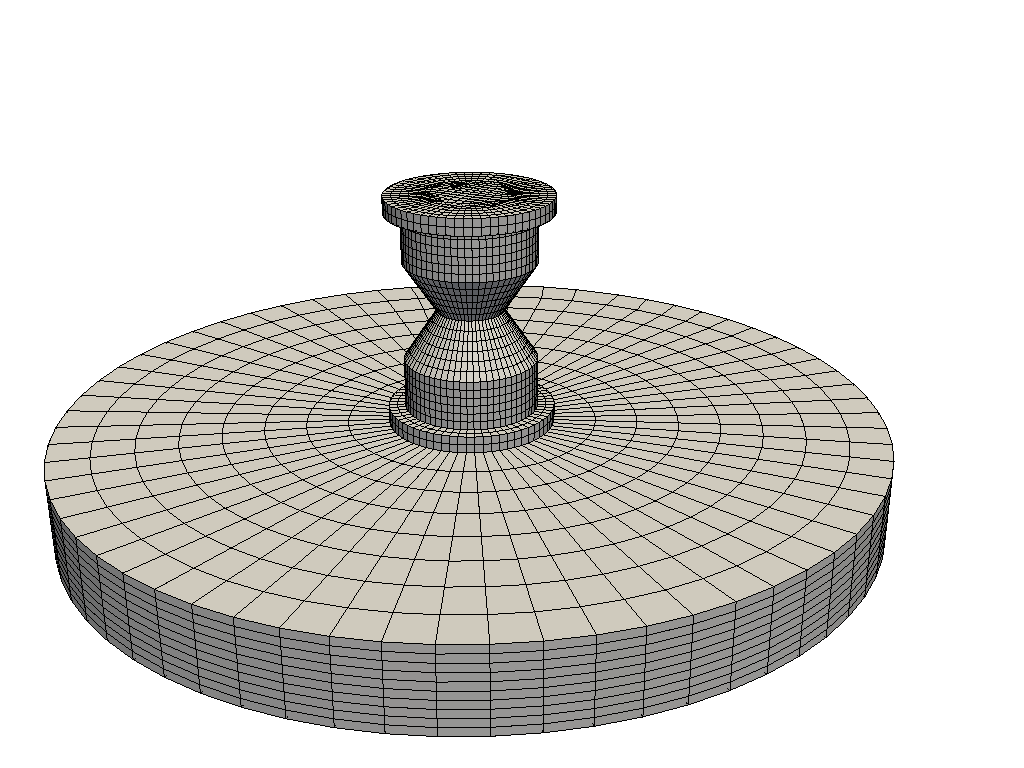

In [4]:
current_time = 1000
zoom = 1.4
display = Display(visible=0)
_ = display.start()
p = pv.Plotter()
active_elements = [element for element, birth_time in zip(elements, birth_list_element) if birth_time <= current_time]
active_nodes = [node for node, birth_time in zip(nodes, birth_list_node) if birth_time <= current_time]
cells = np.array([item for sublist in active_elements for item in [8] + sublist])
cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
points = np.array(nodes)

grid = pv.UnstructuredGrid(cells, cell_type, points)

p.add_mesh(grid, show_edges=True, color='white')

p.camera_position = [(200/zoom, 100/zoom, 100/zoom),(10.0, 10.0, 10.0), (0.0, 0.0, 1.0)]
p.show()

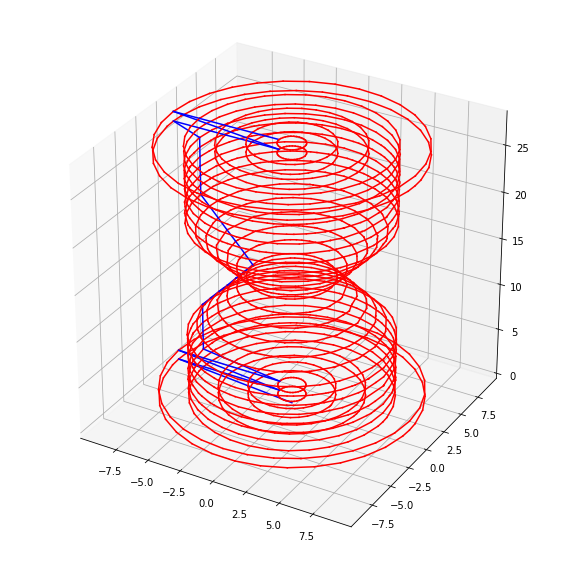

In [7]:
toolpath_np = np.loadtxt('toolpath.crs')
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
for i in range(toolpath_np.shape[0]-1):
    ax.plot(toolpath_np[i:i+2, 1], 
            toolpath_np[i:i+2, 2], 
            toolpath_np[i:i+2, 3], 
            color='red' if toolpath_np[i+1,4]==1 else 'blue')
fig.tight_layout()
plt.show()

### Set up taichi parameters

In [4]:
np.random.seed(1)
real = ti.f32
intg = ti.i32
ti.init(default_fp = real, cpu_max_num_threads=10)
scalar = lambda: ti.field(dtype=real)

loss = scalar()

ambient, cp, cond, Qin, r_beam, h_conv = scalar(), scalar(), scalar(), scalar(), scalar(), scalar()

elements_node_ids = ti.Vector.field(8, dtype = intg)
node_position = ti.Vector.field(3, dtype = real)
element_surface_ids = ti.Matrix.field(6, 4, dtype = intg)
element_birth = scalar()
node_birth = scalar()
surface_birth = ti.Matrix.field(6, 2, dtype = real)

Nip_element = ti.Matrix.field(8, 1, dtype= real)
Bip_element = ti.Matrix.field(3, 8, dtype = real)
Nip_surface = ti.Vector.field(4, dtype = real)

temperature = scalar()
m_vec = scalar()
rhs = scalar()
target = scalar()

laser_loc = ti.Vector.field(3, dtype = real)
laser_on = scalar()

laser_sec_z = scalar()
laser_sec_on = scalar()

steps = int(endTime/dt) + 1
nn = len(nodes)
nel = len(elements)
max_temp = 2000.0

ambient_init = 400.0
density = 0.03
cp_init = 0.5
cond_init = 0.01
Qin_init = 1000.0
r_beam_init = 1.0
h_conv_init = 0.005
h_rad = 0.3

depth_target = 1.5

n_input = 3
n_hidden_1 = 50
n_hidden_2 = 50
n_hidden_3 = 1

learning_rate = 1e-2

beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-7

weight1 = scalar()
weight1_m = scalar()
weight1_v = scalar()
bias1 = scalar()
bias1_m = scalar()
bias1_v = scalar()
output1 = scalar()
weight2 = scalar()
weight2_m = scalar()
weight2_v = scalar()
bias2 = scalar()
bias2_m = scalar()
bias2_v = scalar()
output2 = scalar()
weight3 = scalar()
weight3_m = scalar()
weight3_v = scalar()
bias3 = scalar()
bias3_m = scalar()
bias3_v = scalar()
output3 = scalar()

target_qin = scalar()

temperature_init = np.ones((steps, nn)) * 300.0

ti.root.dense(ti.l, steps).dense(ti.i, nn).place(temperature, target)
ti.root.dense(ti.i, nn).place(m_vec, rhs)
ti.root.dense(ti.i, nel).place(elements_node_ids, element_surface_ids, element_birth, surface_birth)
ti.root.dense(ti.i, nn).place(node_position, node_birth)
ti.root.dense(ti.i, 8).place(Nip_element, Bip_element)
ti.root.dense(ti.i, 4).place(Nip_surface)
ti.root.dense(ti.l, steps).place(laser_loc, laser_on)
ti.root.place(loss, ambient, cp, cond, Qin, r_beam, h_conv)
ti.root.dense(ti.l, steps).place(laser_sec_z, laser_sec_on)

ti.root.dense(ti.ij, (n_hidden_1, n_input)).place(weight1, weight1_m, weight1_v)
ti.root.dense(ti.i, n_hidden_1).place(bias1, bias1_m, bias1_v)
ti.root.dense(ti.ij, (steps, n_hidden_1)).place(output1)
ti.root.dense(ti.ij, (n_hidden_2, n_hidden_1)).place(weight2, weight2_m, weight2_v)
ti.root.dense(ti.i, n_hidden_2).place(bias2, bias2_m, bias2_v)
ti.root.dense(ti.ij, (steps, n_hidden_2)).place(output2)    
ti.root.dense(ti.ij, (n_hidden_3, n_hidden_2)).place(weight3, weight3_m, weight3_v)
ti.root.dense(ti.i, n_hidden_3).place(bias3, bias3_m, bias3_v)
ti.root.dense(ti.ij, (steps, n_hidden_3)).place(output3)        
ti.root.dense(ti.ij,(steps, 1)).place(target_qin)


ti.root.lazy_grad()

Nip_element.from_numpy(Nip_ele)
Bip_element.from_numpy(Bip_ele)
Nip_surface.from_numpy(Nip_sur)
elements_node_ids.from_numpy(np.array(elements))
node_position.from_numpy(np.array(nodes))
element_surface_ids.from_numpy(element_surface)

node_birth.from_numpy(np.array(birth_list_node))
element_birth.from_numpy(np.array(birth_list_element))
surface_birth.from_numpy(element_surface_birth)

laser_loc.from_numpy(np.array(toolpath))
laser_on.from_numpy(np.array(state))

target_q_np = np.load('target_q.npy')
target_qin.from_numpy(target_q_np)

target_np = np.load('target.npy')
target.from_numpy(target_np)

[Taichi] Starting on arch=x64
[Taichi] materializing...


### Simulation

In [5]:
@ti.kernel
def nn1(t: ti.i32):
    for i in range(n_hidden_1):
        act = 0.0
        for j in ti.static(range(n_input)):
            act += weight1[i, j] * (((t / steps) - 0.5))**j
        act += bias1[i]
        act = ti.tanh(act)
        output1[t, i] = act
        
@ti.kernel
def nn2(t: ti.i32):
    for i in range(n_hidden_2):
        act = 0.0
        for j in ti.static(range(n_hidden_1)):
            act += weight2[i, j] * output1[t, j] 
        act += bias2[i]
        act = ti.tanh(act)
        output2[t, i] = act
        
@ti.kernel
def nn3(t: ti.i32):
    for i in range(1):
        act = 0.0
        for j in ti.static(range(n_hidden_2)):
            act += weight3[i, j] * output2[t, j]
        act += bias3[i]
        act = ti.tanh(act)
        output3[t, i] = (act+1)/2.0

        
weight_multiplier = 4.0
bias_multiplier = 0.5

def init_weights():
    for i in range(n_hidden_1):
        for j in range(n_input):
            weight1[i, j] = np.random.randn() * np.sqrt(2/n_input) * 10.0
            weight1_m[i, j] = 0.0
            weight1_v[i, j] = 0.0
        bias1[i] = np.random.uniform(-1* bias_multiplier, bias_multiplier)
        bias1_m[i] = 0.0
        bias1_v[i] = 0.0
    for i in range(n_hidden_2):
        for j in range(n_hidden_1):
            weight2[i, j] = np.random.randn() * np.sqrt(2/n_hidden_1) * 5.0
            weight2_m[i, j] = 0.0
            weight2_v[i, j] = 0.0
        bias2[i] = np.random.uniform(-1* bias_multiplier, bias_multiplier)
        bias2_m[i] = 0.0
        bias2_v[i] = 0.0
        
    for i in range(n_hidden_3):
        for j in range(n_hidden_2):
            weight3[i, j] = np.random.randn() * np.sqrt(2/n_hidden_2) * 2.0
            weight3_m[i, j] = 0.0
            weight3_v[i, j] = 0.0
        bias3[i] = np.random.uniform(-1* bias_multiplier, bias_multiplier)
        bias3_m[i] = 0.0
        bias3_v[i] = 0.0
    
@ti.func
def adam(g, m, v, t):
    m = beta_1*m + (1-beta_1)*g
    v = beta_2*v + (1-beta_2)*(g*g)
    m_cap = m/(1-(beta_1**t))
    v_cap = v/(1-(beta_2**t))
    update = m_cap/(ti.sqrt(v_cap)+epsilon)
    return m, v, update

@ti.kernel
def update_weights_adam(t: intg):
    for i in range(n_hidden_1):
        for j in range(n_input):
            weight1_m[i,j],weight1_v[i,j],update = adam(weight1.grad[i,j],weight1_m[i,j],weight1_v[i,j],t)
            weight1[i, j] = weight1[i, j] - update * learning_rate
        bias1_m[i], bias1_v[i], update = adam(bias1.grad[i], bias1_m[i], bias1_v[i], t)
        bias1[i] = bias1[i] - update * learning_rate

    for i in range(n_hidden_2):
        for j in range(n_hidden_1):
            weight2_m[i,j],weight2_v[i,j],update = adam(weight2.grad[i,j],weight2_m[i,j],weight2_v[i,j],t)
            weight2[i, j] = weight2[i, j] - update * learning_rate    
        bias2_m[i], bias2_v[i], update = adam(bias2.grad[i], bias2_m[i], bias2_v[i], t)
        bias2[i] = bias2[i] - update * learning_rate

    for i in range(n_hidden_3):
        for j in range(n_hidden_2):
            weight3_m[i,j],weight3_v[i,j],update = adam(weight3.grad[i,j],weight3_m[i,j],weight3_v[i,j],t)
            weight3[i, j] = weight3[i, j] - update * learning_rate  
        bias3_m[i], bias3_v[i], update = adam(bias3.grad[i], bias3_m[i], bias3_v[i], t)
        bias3[i] = bias3[i] - update * learning_rate


In [6]:
def plot_qin(output):
    fig, axs = plt.subplots(1,1, figsize = (6,3))
    axs.plot(np.arange(0.0, endTime, dt),target_q_np, 'C0--', label='Target')
    axs.plot(np.arange(0.0, endTime, dt),output[:,0], 'C1', label='Current')
    axs.legend()
    plt.show()

### Test neural networks

In [7]:
@ti.kernel
def compute_loss_nn():
    for t in range(steps):
        ti.atomic_add(loss[None], (output3[t, 0] - target_qin[t, 0])**2)
            
def forward_just_nn():
    for t in range(0, steps):        
        nn1(t)
        nn2(t)
        nn3(t)

#     compute_loss_nn()

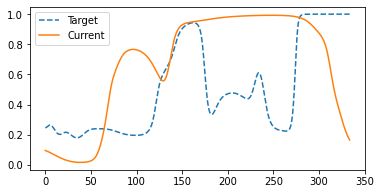

In [8]:
init_weights()
# # with ti.Tape(loss):
forward_just_nn()
output_Qin = output3.to_numpy()
plot_qin(output_Qin)

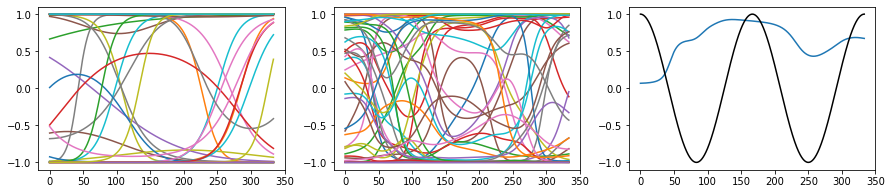

In [22]:
# init_weights()
# # with ti.Tape(loss):
# forward()
output1_lo = output1.to_numpy()
output2_lo = output2.to_numpy()
output3_lo = output3.to_numpy()

fig, axs = plt.subplots(1,3, figsize = (15,3))
for i in range(50):
    axs[0].plot(np.arange(0.0, endTime, dt),output1_lo[:,i], label='1')
for i in range(50):
    axs[1].plot(np.arange(0.0, endTime, dt),output2_lo[:,i], label='2')
axs[2].plot(np.arange(0.0, endTime, dt),output3_lo[:,0], label='4')
axs[2].plot(np.arange(0.0, endTime, dt),target_loc_np[:,1], 'black')  
plt.show()

It:0, Loss:5.23E+04


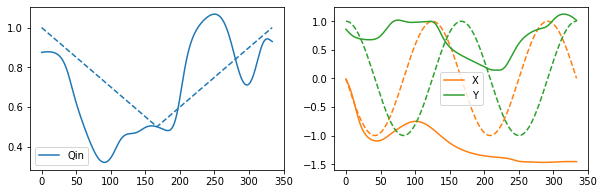

It:1, Loss:3.06E+04
It:2, Loss:3.20E+04
It:3, Loss:2.72E+04
It:4, Loss:1.81E+04
It:5, Loss:1.27E+04
It:6, Loss:1.06E+04
It:7, Loss:8.32E+03
It:8, Loss:5.80E+03
It:9, Loss:4.74E+03
It:10, Loss:4.97E+03


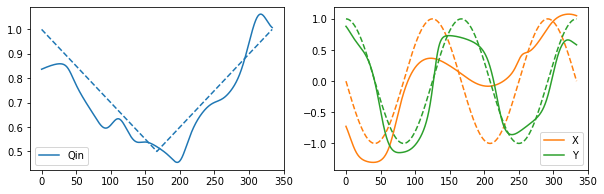

It:11, Loss:5.33E+03
It:12, Loss:5.26E+03
It:13, Loss:4.75E+03
It:14, Loss:3.97E+03
It:15, Loss:3.27E+03
It:16, Loss:2.95E+03
It:17, Loss:3.00E+03
It:18, Loss:3.09E+03
It:19, Loss:3.02E+03
It:20, Loss:2.83E+03


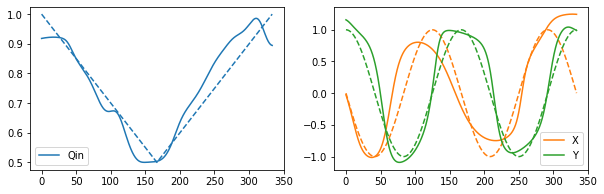

It:21, Loss:2.65E+03
It:22, Loss:2.55E+03
It:23, Loss:2.50E+03
It:24, Loss:2.41E+03
It:25, Loss:2.20E+03
It:26, Loss:1.90E+03
It:27, Loss:1.59E+03
It:28, Loss:1.36E+03
It:29, Loss:1.23E+03
It:30, Loss:1.16E+03


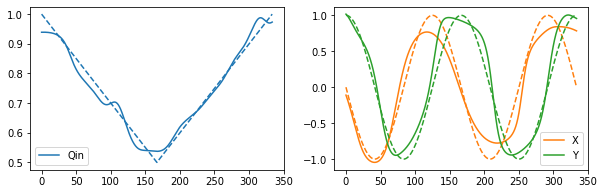

It:31, Loss:1.08E+03
It:32, Loss:9.46E+02
It:33, Loss:8.42E+02
It:34, Loss:8.34E+02
It:35, Loss:8.73E+02
It:36, Loss:8.81E+02
It:37, Loss:8.43E+02
It:38, Loss:7.82E+02
It:39, Loss:7.26E+02
It:40, Loss:6.99E+02


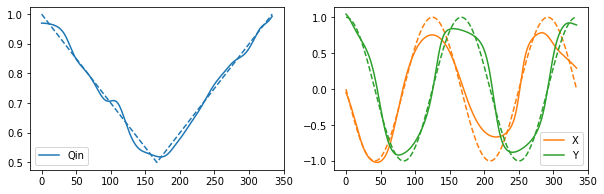

It:41, Loss:6.79E+02
It:42, Loss:6.25E+02
It:43, Loss:5.54E+02
It:44, Loss:5.09E+02
It:45, Loss:4.95E+02
It:46, Loss:4.83E+02
It:47, Loss:4.62E+02
It:48, Loss:4.37E+02
It:49, Loss:4.20E+02
It:50, Loss:4.19E+02


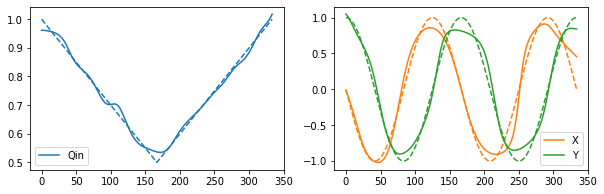

It:51, Loss:4.22E+02
It:52, Loss:4.08E+02
It:53, Loss:3.87E+02
It:54, Loss:3.76E+02
It:55, Loss:3.72E+02
It:56, Loss:3.61E+02
It:57, Loss:3.42E+02
It:58, Loss:3.23E+02
It:59, Loss:3.08E+02
It:60, Loss:2.97E+02


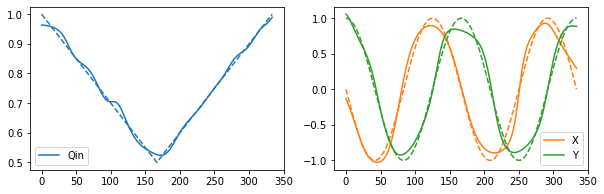

It:61, Loss:2.84E+02
It:62, Loss:2.68E+02
It:63, Loss:2.54E+02
It:64, Loss:2.47E+02
It:65, Loss:2.41E+02
It:66, Loss:2.32E+02
It:67, Loss:2.24E+02
It:68, Loss:2.18E+02
It:69, Loss:2.13E+02
It:70, Loss:2.06E+02


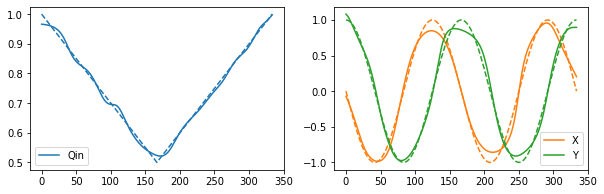

It:71, Loss:1.97E+02
It:72, Loss:1.89E+02
It:73, Loss:1.82E+02
It:74, Loss:1.76E+02
It:75, Loss:1.69E+02
It:76, Loss:1.62E+02
It:77, Loss:1.58E+02
It:78, Loss:1.54E+02
It:79, Loss:1.49E+02
It:80, Loss:1.44E+02


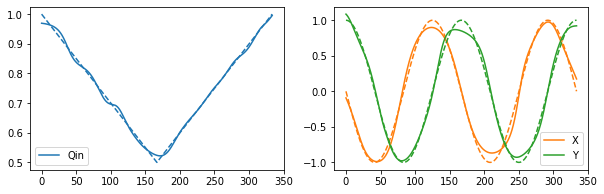

It:81, Loss:1.40E+02
It:82, Loss:1.36E+02
It:83, Loss:1.32E+02
It:84, Loss:1.27E+02
It:85, Loss:1.23E+02
It:86, Loss:1.20E+02
It:87, Loss:1.16E+02
It:88, Loss:1.12E+02
It:89, Loss:1.09E+02
It:90, Loss:1.06E+02


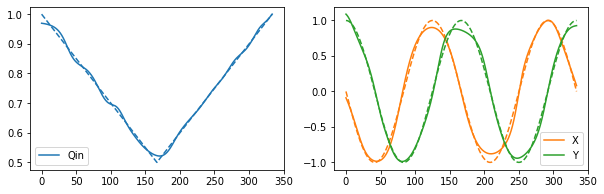

It:91, Loss:1.04E+02
It:92, Loss:1.01E+02
It:93, Loss:9.83E+01
It:94, Loss:9.61E+01
It:95, Loss:9.39E+01
It:96, Loss:9.15E+01
It:97, Loss:8.91E+01
It:98, Loss:8.69E+01
It:99, Loss:8.49E+01
It:100, Loss:8.28E+01


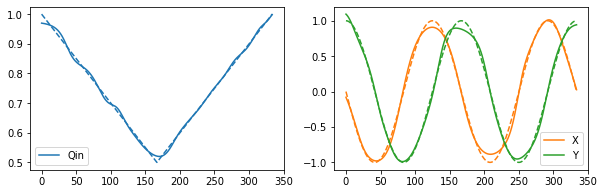

It:101, Loss:8.09E+01
It:102, Loss:7.92E+01
It:103, Loss:7.76E+01
It:104, Loss:7.60E+01
It:105, Loss:7.45E+01
It:106, Loss:7.31E+01
It:107, Loss:7.17E+01
It:108, Loss:7.04E+01
It:109, Loss:6.91E+01
It:110, Loss:6.79E+01


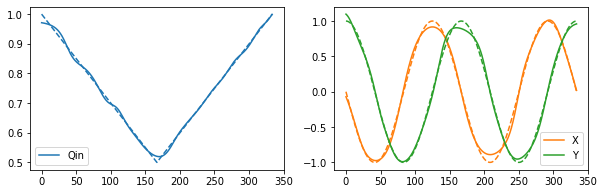

It:111, Loss:6.67E+01
It:112, Loss:6.55E+01
It:113, Loss:6.44E+01
It:114, Loss:6.33E+01
It:115, Loss:6.23E+01
It:116, Loss:6.13E+01
It:117, Loss:6.03E+01
It:118, Loss:5.93E+01
It:119, Loss:5.84E+01
It:120, Loss:5.75E+01


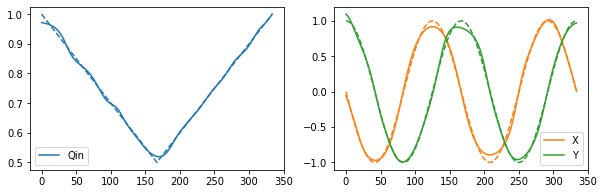

It:121, Loss:5.66E+01
It:122, Loss:5.57E+01
It:123, Loss:5.49E+01
It:124, Loss:5.41E+01
It:125, Loss:5.33E+01
It:126, Loss:5.25E+01
It:127, Loss:5.18E+01
It:128, Loss:5.11E+01
It:129, Loss:5.04E+01
It:130, Loss:4.97E+01


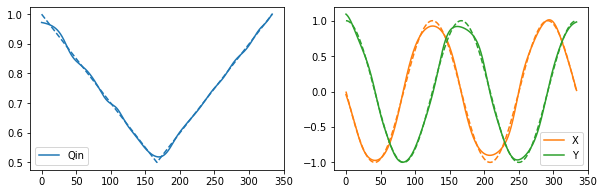

It:131, Loss:4.91E+01
It:132, Loss:4.84E+01
It:133, Loss:4.78E+01
It:134, Loss:4.72E+01
It:135, Loss:4.66E+01
It:136, Loss:4.61E+01
It:137, Loss:4.55E+01
It:138, Loss:4.50E+01
It:139, Loss:4.45E+01
It:140, Loss:4.40E+01


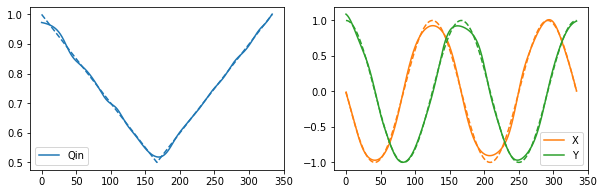

It:141, Loss:4.35E+01
It:142, Loss:4.30E+01
It:143, Loss:4.26E+01
It:144, Loss:4.21E+01
It:145, Loss:4.17E+01
It:146, Loss:4.13E+01
It:147, Loss:4.09E+01
It:148, Loss:4.05E+01
It:149, Loss:4.01E+01
It:150, Loss:3.97E+01


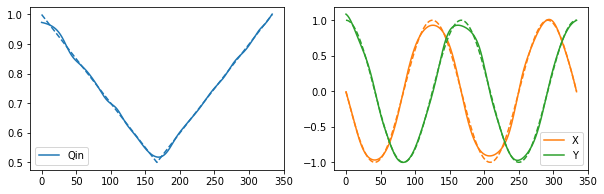

It:151, Loss:3.93E+01
It:152, Loss:3.89E+01
It:153, Loss:3.86E+01
It:154, Loss:3.82E+01
It:155, Loss:3.78E+01
It:156, Loss:3.75E+01
It:157, Loss:3.72E+01
It:158, Loss:3.68E+01
It:159, Loss:3.64E+01
It:160, Loss:3.61E+01


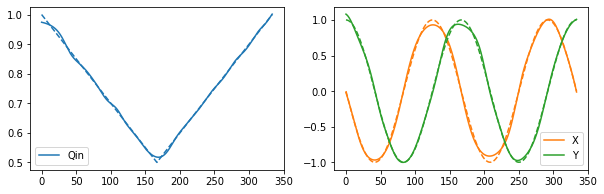

It:161, Loss:3.57E+01
It:162, Loss:3.54E+01
It:163, Loss:3.50E+01
It:164, Loss:3.47E+01
It:165, Loss:3.44E+01
It:166, Loss:3.41E+01
It:167, Loss:3.37E+01
It:168, Loss:3.34E+01
It:169, Loss:3.30E+01
It:170, Loss:3.27E+01


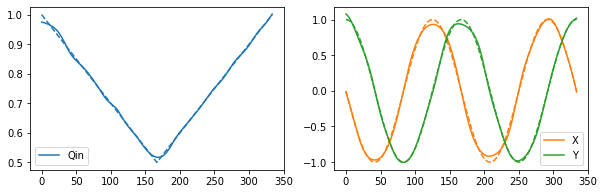

It:171, Loss:3.24E+01
It:172, Loss:3.20E+01
It:173, Loss:3.18E+01
It:174, Loss:3.14E+01
It:175, Loss:3.13E+01
It:176, Loss:3.09E+01


KeyboardInterrupt: 

In [38]:
losses = []

for iter in range(200):
    loss[None] = 0.0
    with ti.Tape(loss):
        forward()
    update_weights_adam(iter+1)
    update_weights_adam_loc(iter+1)
    update_weights_adam_loc2(iter+1)
    losses.append(loss[None])
    print("It:{:d}, Loss:{:.2E}".format(iter, loss[None]))
    
    if iter%10 ==0:
        output_Qin = output3.to_numpy()
        output_loc = output3_loc.to_numpy()
        output_loc2 = output3_loc2.to_numpy()
        plot_qin(output_Qin, output_loc, output_loc2)

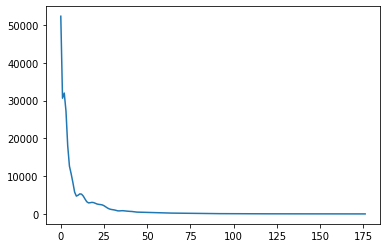

In [39]:
plt.plot(losses)

### differentiable thermal FEM

In [7]:
@ti.kernel
def clear_grads():
    Qin.grad[None] = 0.0

def initialize_temp():
    temperature.from_numpy(temperature_init)

def initialize_params():
    ambient[None] = ambient_init
    cp[None] = cp_init
    cond[None] = cond_init
    Qin[None] = Qin_init
    r_beam[None] = r_beam_init
    h_conv[None] = h_conv_init
    
def initialize():
    initialize_temp()
    initialize_params()
    
@ti.kernel
def clear_vectors():
    for i in range(nn):
        m_vec[i] = 0.0
        rhs[i] = 0.0
        
@ti.kernel
def time_integrate(t: intg, dt: real):
    for i in range(nn):
        if node_birth[i] <= t*dt:
            temperature[t, i] = min(temperature[t-1, i] + dt * rhs[i] / m_vec[i], max_temp)
            
@ti.func
def clac_mass(t, el_id, density, cp):
    mass = ti.Vector.zero(real, 8, 8)
    lump_mass = ti.Vector.zero(real, 8)
    nodes_pos = ti.Matrix.rows([node_position[elements_node_ids[el_id][0]],
                                node_position[elements_node_ids[el_id][1]],
                                node_position[elements_node_ids[el_id][2]],
                                node_position[elements_node_ids[el_id][3]],
                                node_position[elements_node_ids[el_id][4]],
                                node_position[elements_node_ids[el_id][5]],
                                node_position[elements_node_ids[el_id][6]],
                                node_position[elements_node_ids[el_id][7]]])
    for intgeration in ti.static(range(8)):
        N = Nip_element[intgeration]
        B = Bip_element[intgeration]
        Jac = B@nodes_pos
        detJac = Jac.determinant()
        mass += density * cp * detJac * N@N.transpose()
    for i in ti.static(range(8)):
        for j in ti.static(range(8)):
            lump_mass[i] += mass[i,j]
    return lump_mass
            
@ti.func
def calc_stiffness(el_id, cond):
    stiffness = ti.Vector.zero(real, 8, 8)
    nodes_pos = ti.Matrix.rows([node_position[elements_node_ids[el_id][0]],
                                node_position[elements_node_ids[el_id][1]],
                                node_position[elements_node_ids[el_id][2]],
                                node_position[elements_node_ids[el_id][3]],
                                node_position[elements_node_ids[el_id][4]],
                                node_position[elements_node_ids[el_id][5]],
                                node_position[elements_node_ids[el_id][6]],
                                node_position[elements_node_ids[el_id][7]]])
    for intgeration in ti.static(range(8)):
        B = Bip_element[intgeration]
        Jac = B@nodes_pos
        detJac = Jac.determinant()
        iJac = Jac.inverse()
        gradN = iJac@B
        stiffness += cond * detJac * gradN.transpose()@gradN
    return stiffness
    
@ti.kernel
def update_mvec(t: intg, dt: real):
    for el_id in range(nel):
        if element_birth[el_id] <= t*dt:
            lump_mass = clac_mass(t, el_id, density, cp[None])
            for i in ti.static(range(8)):
                m_vec[elements_node_ids[el_id][i]] += lump_mass[i]

@ti.kernel
def update_stiffness(t: intg, dt: real):
    for el_id in range(nel):
        if element_birth[el_id] <= t*dt:
            stiffness = calc_stiffness(el_id, cond[None])
            temperature_nodes = ti.Matrix.rows([[temperature[t-1, elements_node_ids[el_id][0]]],
                                                [temperature[t-1, elements_node_ids[el_id][1]]],
                                                [temperature[t-1, elements_node_ids[el_id][2]]],
                                                [temperature[t-1, elements_node_ids[el_id][3]]],
                                                [temperature[t-1, elements_node_ids[el_id][4]]],
                                                [temperature[t-1, elements_node_ids[el_id][5]]],
                                                [temperature[t-1, elements_node_ids[el_id][6]]],
                                                [temperature[t-1, elements_node_ids[el_id][7]]]])
            stiff_temp = stiffness@temperature_nodes
            for i in ti.static(range(8)):
                rhs[elements_node_ids[el_id][i]] -= stiff_temp[i]

@ti.kernel
def update_fluxes_m(t: intg, dt: real):
    for el_id in range(nel):
        if element_birth[el_id] <= t*dt:
            for sur_id in ti.static(range(6)):
                if surface_birth[el_id][sur_id, 0] <= t*dt and surface_birth[el_id][sur_id, 1] > t*dt:
                    for ip in ti.static(range(4)):
                        N = Nip_surface[ip]
                        ip_pos = node_position[element_surface_ids[el_id][sur_id, ip]]
                        r2 = (ip_pos[0]-laser_loc[t][0])**2+(ip_pos[1]-laser_loc[t][1])**2+(ip_pos[2]-laser_loc[t][2])**2
                        qmov = 3.0 * Qin[None] * output3[t, 0] * laser_on[t]/(3.14 * r_beam[None]**2)*ti.exp(-3.0 * r2 / (r_beam[None]**2))
#                         qmov = 3.0 * Qin[None] * target_qin[t, 0] * laser_on[t] /(3.14 * r_beam[None]**2)*ti.exp(-3.0 * r2 / (r_beam[None]**2))
                        for i in ti.static(range(4)):
                            rhs[element_surface_ids[el_id][sur_id, i]] += N[i] * qmov * 0.25

                            
@ti.kernel
def update_fluxes_cr(t: intg, dt: real):
    for el_id in range(nel):
        if element_birth[el_id] <= t*dt:
            for sur_id in ti.static(range(6)):
                if surface_birth[el_id][sur_id, 0] <= t*dt and surface_birth[el_id][sur_id, 1] > t*dt:
                    temperature_nodes = ti.Vector([temperature[t-1, element_surface_ids[el_id][sur_id, 0]],
                                                   temperature[t-1,element_surface_ids[el_id][sur_id, 1]],
                                                   temperature[t-1,element_surface_ids[el_id][sur_id, 2]],
                                                   temperature[t-1,element_surface_ids[el_id][sur_id, 3]]])
                    for ip in ti.static(range(4)):
                        N = Nip_surface[ip]
                        temperature_ip = N.dot(temperature_nodes)
                        qconv = -1 * h_conv[None] * (temperature_ip - ambient[None])
                        qrad = -1 * 5.67e-14 * h_rad * (temperature_ip - ambient[None])**4
                        for i in ti.static(range(4)):
                            rhs[element_surface_ids[el_id][sur_id, i]] += N[i] * (qconv + qrad) * 0.25

@ti.kernel
def compute_loss():
    for t, i in ti.ndrange(steps, nn):
        ti.atomic_add(loss, (temperature[t, i] - target[t, i])**2)

    
def simulate():
    nn1(0)
    nn2(0)
    nn3(0)

    for time_step in range(1, steps):
#         print(100*time_step/steps, "%")
        clear_vectors()
        nn1(time_step)
        nn2(time_step)
        nn3(time_step)        
        
        update_mvec(time_step, dt)
        update_stiffness(time_step, dt)
        update_fluxes_m(time_step, dt)
        update_fluxes_cr(time_step, dt)
        time_integrate(time_step, dt)
        
    compute_loss()

### Test run and visualization

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

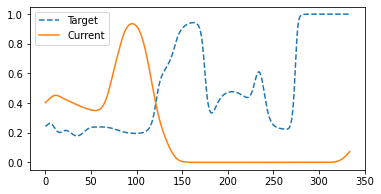

In [10]:
loss[None] = 0.0
init_weights()

initialize()
clear_grads()
# with ti.Tape(loss):
simulate()
temperature_out = temperature.to_numpy()
output_Qin = output3.to_numpy()
plot_qin(output_Qin)

In [23]:
loss[None]

52349870080.0

In [24]:
weight1.grad[1,0]

12753556480.0

In [25]:
weight1[1,0]

-8.760851860046387

In [19]:
learning_rate

0.0001

In [20]:
update_weights_adam(1)

In [21]:
weight1[1,0]

-8.760851860046387

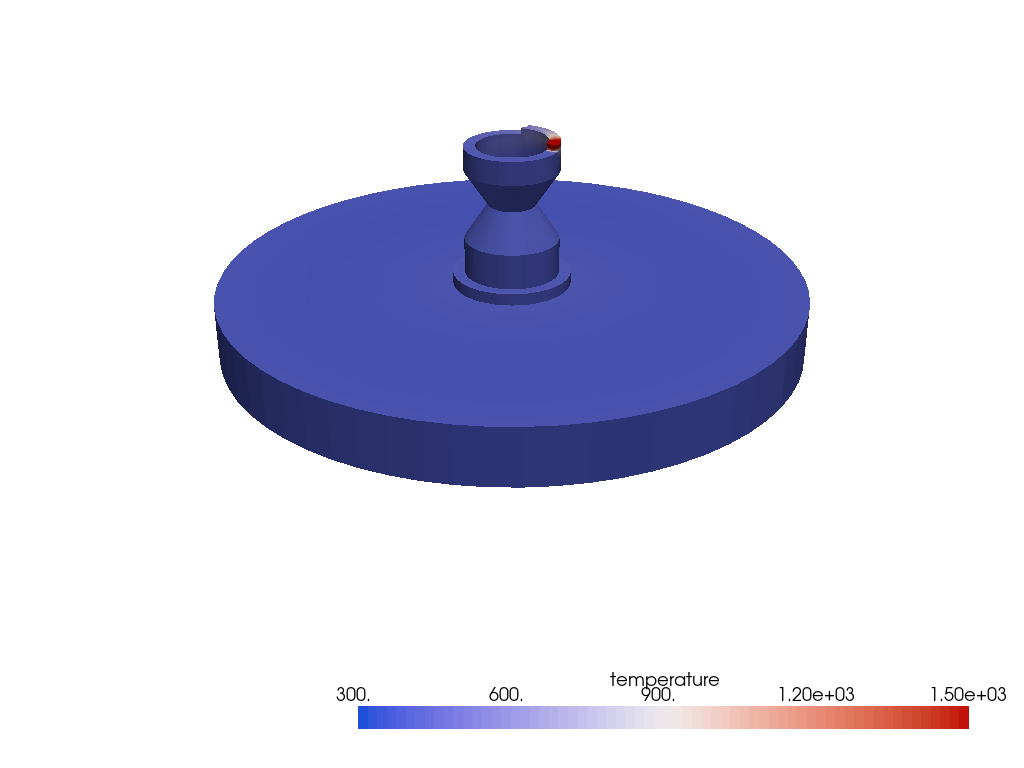

In [11]:
time_step = 12000
zoom = 1.0

display = Display(visible=0)
_ = display.start()

active_elements = [element for element, birth_time in zip(elements, birth_list_element) if birth_time <= time_step*dt]
active_nodes = [node for node, birth_time in zip(nodes, birth_list_node) if birth_time <= time_step*dt]

cells = np.array([item for sublist in active_elements for item in [8] + sublist])
cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
points = np.array(nodes)
grid = pv.UnstructuredGrid(cells, cell_type, points)
grid.point_arrays['temperature'] = temperature_out[time_step]

p = pv.Plotter()
p.add_mesh(grid, show_edges=False, color='white',scalars='temperature', cmap="coolwarm",clim = [300, 1500],)
p.camera_position = [(200/zoom, 100/zoom, 100/zoom),(0.0, 0, -20.0),(0.0, 0.0, 1.0)]
p.show()

In [12]:
zoom = 1.0
filename = "animation.gif"
p = pv.Plotter()
p.open_gif(filename)
for time_step in np.linspace(0, temperature_out.shape[0]-1, 50, dtype=np.int):
    active_elements = [element for element, birth_time in zip(elements, birth_list_element) if birth_time <= time_step*dt]
    active_nodes = [node for node, birth_time in zip(nodes, birth_list_node) if birth_time <= time_step*dt]
    cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = np.array(nodes)
    grid = pv.UnstructuredGrid(cells, cell_type, points)
    grid.point_arrays['temperature'] = temperature_out[time_step]
    p.add_mesh(grid, show_edges=True, color='white',scalars='temperature', cmap="coolwarm",clim = [300, 1500],)
    p.camera_position = [(200/zoom, 100/zoom, 100/zoom),(0.0, 0, -20.0),(0.0, 0.0, 1.0)]
    p.write_frame()
p.close()
HTML('<img src="{}">'.format(filename))

In [13]:
np.save('target', temperature_out)

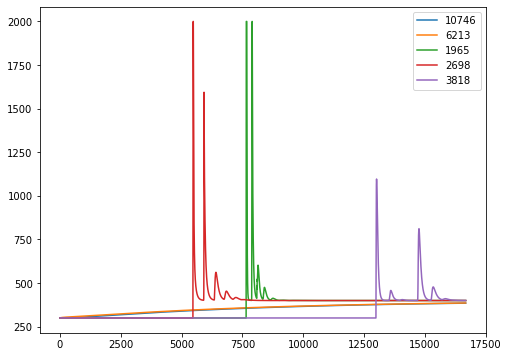

In [15]:
fig = plt.figure(figsize=(8,6))
for ind in np.random.randint(0, nn, size = (5)):
    theta_id = [theta[ind] for theta in temperature_out]
    plt.plot(range(len(theta_id)),theta_id, label=str(ind))
plt.legend()
plt.show()

### Optimize

In [8]:
learning_rate

0.01

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen


  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/home/mmv664/anaconda3/envs/myenv

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

    x = ti.field(ti.f32, (8, 8)).
 See https://taichi.readthedocs.io/en/stable/tensor_matrix.html#matrix-size for more details.

  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/mmv664/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/mmv664/anaconda3/envs/myen

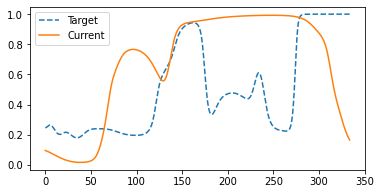

In [9]:
his = []
outputs_Qin = []

loss[None] = 0.0
init_weights()

initialize()
clear_grads()
with ti.Tape(loss):
    simulate()
    
outputs_Qin.append(output3.to_numpy())
plot_qin(outputs_Qin[0])

It:1, Loss:9.24E+10, T:17.11


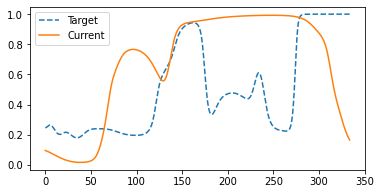

It:2, Loss:1.08E+11, T:17.04
It:3, Loss:3.97E+10, T:17.04
It:4, Loss:3.32E+10, T:16.99
It:5, Loss:3.15E+10, T:17.01
It:6, Loss:2.55E+10, T:17.01
It:7, Loss:3.10E+10, T:16.98
It:8, Loss:4.00E+10, T:17.06
It:9, Loss:3.58E+10, T:16.98
It:10, Loss:2.54E+10, T:17.11
It:11, Loss:1.96E+10, T:17.06


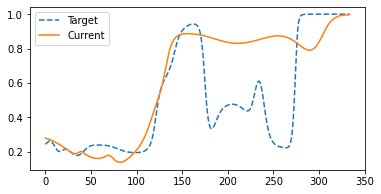

It:12, Loss:1.73E+10, T:16.97
It:13, Loss:1.34E+10, T:16.91
It:14, Loss:9.65E+09, T:16.99
It:15, Loss:1.22E+10, T:16.93
It:16, Loss:9.67E+09, T:17.04
It:17, Loss:8.89E+09, T:17.06
It:18, Loss:9.57E+09, T:16.99
It:19, Loss:8.00E+09, T:17.12
It:20, Loss:7.40E+09, T:16.92
It:21, Loss:9.47E+09, T:17.00


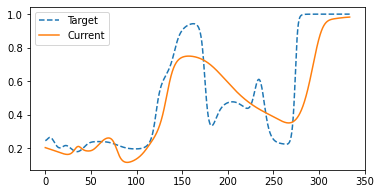

It:22, Loss:9.88E+09, T:17.32
It:23, Loss:7.86E+09, T:17.36
It:24, Loss:6.85E+09, T:17.47
It:25, Loss:6.93E+09, T:17.49
It:26, Loss:5.79E+09, T:17.48
It:27, Loss:4.50E+09, T:17.57
It:28, Loss:4.97E+09, T:17.45
It:29, Loss:5.41E+09, T:17.45
It:30, Loss:4.57E+09, T:17.44
It:31, Loss:4.28E+09, T:17.46


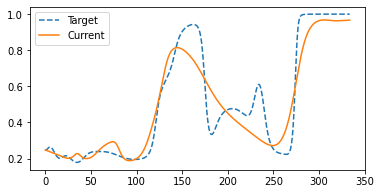

It:32, Loss:4.59E+09, T:17.48
It:33, Loss:4.23E+09, T:17.49
It:34, Loss:3.75E+09, T:17.44
It:35, Loss:3.99E+09, T:17.48
It:36, Loss:4.16E+09, T:17.51
It:37, Loss:3.66E+09, T:17.45
It:38, Loss:3.36E+09, T:17.49
It:39, Loss:3.54E+09, T:17.52
It:40, Loss:3.54E+09, T:17.47
It:41, Loss:3.30E+09, T:17.49


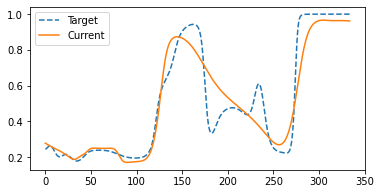

It:42, Loss:3.29E+09, T:17.41
It:43, Loss:3.40E+09, T:17.44
It:44, Loss:3.22E+09, T:17.50
It:45, Loss:3.00E+09, T:17.49
It:46, Loss:3.06E+09, T:17.48
It:47, Loss:3.10E+09, T:17.49
It:48, Loss:2.96E+09, T:17.49
It:49, Loss:2.93E+09, T:17.47
It:50, Loss:3.00E+09, T:17.46
It:51, Loss:2.91E+09, T:17.45


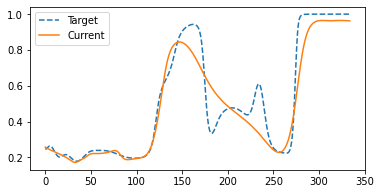

It:52, Loss:2.79E+09, T:17.54
It:53, Loss:2.81E+09, T:17.48
It:54, Loss:2.83E+09, T:17.49
It:55, Loss:2.78E+09, T:17.47
It:56, Loss:2.79E+09, T:17.44
It:57, Loss:2.83E+09, T:17.45
It:58, Loss:2.75E+09, T:17.42
It:59, Loss:2.66E+09, T:17.49
It:60, Loss:2.64E+09, T:17.46
It:61, Loss:2.62E+09, T:17.55


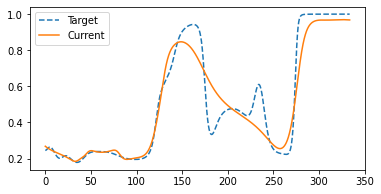

It:62, Loss:2.58E+09, T:17.46
It:63, Loss:2.58E+09, T:17.43
It:64, Loss:2.58E+09, T:17.43
It:65, Loss:2.54E+09, T:17.45
It:66, Loss:2.52E+09, T:17.48
It:67, Loss:2.52E+09, T:17.46
It:68, Loss:2.49E+09, T:17.48
It:69, Loss:2.47E+09, T:17.55
It:70, Loss:2.48E+09, T:17.43
It:71, Loss:2.47E+09, T:17.45


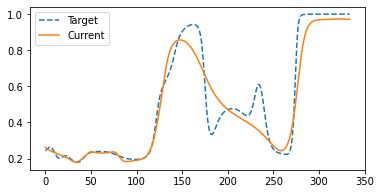

It:72, Loss:2.44E+09, T:17.47
It:73, Loss:2.42E+09, T:17.45
It:74, Loss:2.41E+09, T:17.47
It:75, Loss:2.39E+09, T:17.49
It:76, Loss:2.39E+09, T:17.42
It:77, Loss:2.38E+09, T:17.34
It:78, Loss:2.36E+09, T:18.71
It:79, Loss:2.34E+09, T:19.44
It:80, Loss:2.33E+09, T:19.44
It:81, Loss:2.31E+09, T:19.38


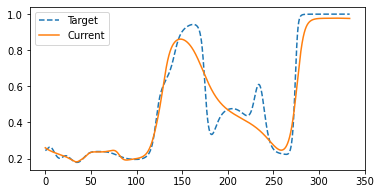

It:82, Loss:2.29E+09, T:19.42
It:83, Loss:2.29E+09, T:19.43
It:84, Loss:2.27E+09, T:19.41
It:85, Loss:2.25E+09, T:19.57
It:86, Loss:2.24E+09, T:19.42
It:87, Loss:2.22E+09, T:19.46
It:88, Loss:2.20E+09, T:19.43
It:89, Loss:2.19E+09, T:19.41
It:90, Loss:2.18E+09, T:19.38
It:91, Loss:2.16E+09, T:19.39


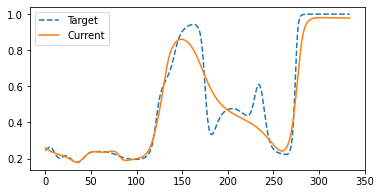

It:92, Loss:2.15E+09, T:19.44
It:93, Loss:2.14E+09, T:19.54
It:94, Loss:2.13E+09, T:19.42
It:95, Loss:2.12E+09, T:19.42
It:96, Loss:2.11E+09, T:19.43
It:97, Loss:2.10E+09, T:19.41
It:98, Loss:2.08E+09, T:19.40
It:99, Loss:2.07E+09, T:19.44
It:100, Loss:2.06E+09, T:19.39
It:101, Loss:2.05E+09, T:19.58


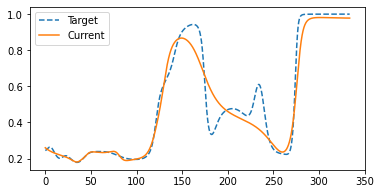

It:102, Loss:2.04E+09, T:19.43
It:103, Loss:2.02E+09, T:19.46
It:104, Loss:2.01E+09, T:19.42
It:105, Loss:2.00E+09, T:19.44
It:106, Loss:1.99E+09, T:19.42
It:107, Loss:1.98E+09, T:19.37
It:108, Loss:1.96E+09, T:19.55
It:109, Loss:1.95E+09, T:19.44
It:110, Loss:1.94E+09, T:19.45
It:111, Loss:1.93E+09, T:19.39


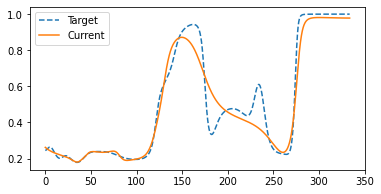

It:112, Loss:1.92E+09, T:19.43
It:113, Loss:1.91E+09, T:19.43
It:114, Loss:1.90E+09, T:19.44
It:115, Loss:1.89E+09, T:19.44
It:116, Loss:1.88E+09, T:19.60
It:117, Loss:1.86E+09, T:19.46
It:118, Loss:1.85E+09, T:19.43
It:119, Loss:1.84E+09, T:19.41
It:120, Loss:1.83E+09, T:19.44
It:121, Loss:1.82E+09, T:19.41


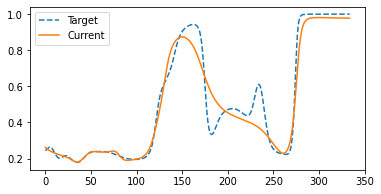

It:122, Loss:1.81E+09, T:19.63
It:123, Loss:1.80E+09, T:19.91
It:124, Loss:1.78E+09, T:19.75
It:125, Loss:1.77E+09, T:19.67
It:126, Loss:1.76E+09, T:19.45
It:127, Loss:1.75E+09, T:19.43
It:128, Loss:1.74E+09, T:19.47
It:129, Loss:1.73E+09, T:19.41
It:130, Loss:1.72E+09, T:19.39
It:131, Loss:1.71E+09, T:19.54


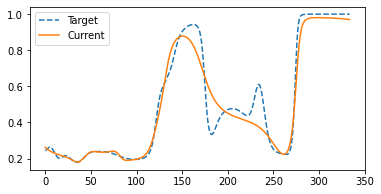

It:132, Loss:1.69E+09, T:19.43
It:133, Loss:1.68E+09, T:19.40
It:134, Loss:1.67E+09, T:19.44
It:135, Loss:1.66E+09, T:19.44
It:136, Loss:1.65E+09, T:19.38
It:137, Loss:1.63E+09, T:19.04
It:138, Loss:1.62E+09, T:19.05
It:139, Loss:1.61E+09, T:19.21
It:140, Loss:1.59E+09, T:19.02
It:141, Loss:1.58E+09, T:19.05


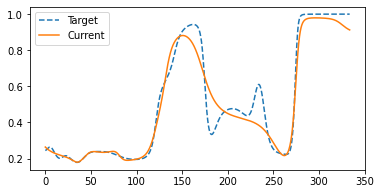

It:142, Loss:1.56E+09, T:19.02
It:143, Loss:1.55E+09, T:19.03
It:144, Loss:1.53E+09, T:19.02
It:145, Loss:1.52E+09, T:19.05
It:146, Loss:1.50E+09, T:19.19
It:147, Loss:1.48E+09, T:19.08
It:148, Loss:1.47E+09, T:19.06
It:149, Loss:1.45E+09, T:19.09
It:150, Loss:1.44E+09, T:19.04
It:151, Loss:1.42E+09, T:19.05


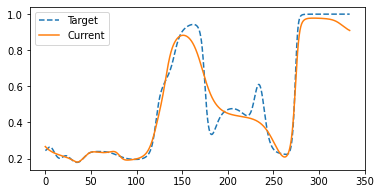

It:152, Loss:1.41E+09, T:19.02
It:153, Loss:1.40E+09, T:19.06
It:154, Loss:1.38E+09, T:19.16
It:155, Loss:1.37E+09, T:19.02
It:156, Loss:1.36E+09, T:19.01
It:157, Loss:1.35E+09, T:19.06
It:158, Loss:1.34E+09, T:19.06
It:159, Loss:1.33E+09, T:19.05
It:160, Loss:1.33E+09, T:19.05
It:161, Loss:1.32E+09, T:19.06


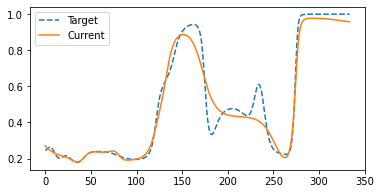

It:162, Loss:1.31E+09, T:19.17
It:163, Loss:1.31E+09, T:19.40
It:164, Loss:1.30E+09, T:19.29
It:165, Loss:1.29E+09, T:19.05
It:166, Loss:1.28E+09, T:19.06
It:167, Loss:1.28E+09, T:19.03
It:168, Loss:1.27E+09, T:19.08
It:169, Loss:1.26E+09, T:19.11
It:170, Loss:1.25E+09, T:19.18
It:171, Loss:1.24E+09, T:19.07


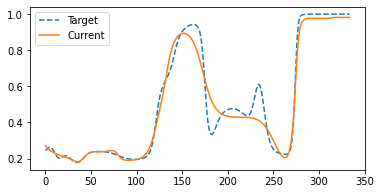

It:172, Loss:1.23E+09, T:19.07
It:173, Loss:1.22E+09, T:19.04
It:174, Loss:1.21E+09, T:19.08
It:175, Loss:1.20E+09, T:19.04
It:176, Loss:1.19E+09, T:19.05
It:177, Loss:1.18E+09, T:19.23
It:178, Loss:1.18E+09, T:19.44
It:179, Loss:1.17E+09, T:19.47
It:180, Loss:1.16E+09, T:19.49
It:181, Loss:1.15E+09, T:19.50


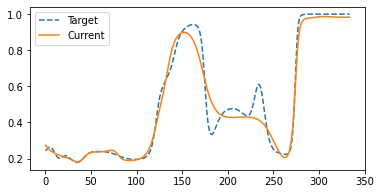

It:182, Loss:1.14E+09, T:19.49
It:183, Loss:1.13E+09, T:19.46
It:184, Loss:1.13E+09, T:19.49
It:185, Loss:1.12E+09, T:19.58
It:186, Loss:1.11E+09, T:19.49
It:187, Loss:1.10E+09, T:19.50
It:188, Loss:1.09E+09, T:19.50
It:189, Loss:1.08E+09, T:19.50
It:190, Loss:1.07E+09, T:19.31
It:191, Loss:1.06E+09, T:19.08


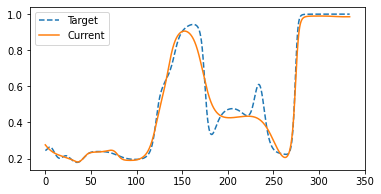

It:192, Loss:1.05E+09, T:19.55
It:193, Loss:1.05E+09, T:19.64
It:194, Loss:1.05E+09, T:19.49
It:195, Loss:1.03E+09, T:19.50
It:196, Loss:1.01E+09, T:19.47
It:197, Loss:1.01E+09, T:19.48
It:198, Loss:1.01E+09, T:19.47
It:199, Loss:9.98E+08, T:19.52
It:200, Loss:9.82E+08, T:20.05


In [10]:
iterations = 200

for it in range(iterations):
    start = time.time()
    loss[None] = 0.0
    clear_grads()
    with ti.Tape(loss):
        simulate()
        
    update_weights_adam(it+1)
    
    end = time.time()
    his.append(loss[None])
    print("It:{:d}, Loss:{:.2E}, T:{:.2f}".format(it+1, loss[None], (end - start)/60.0))
    
    outputs_Qin.append(output3.to_numpy())
    
    if it%10 ==0:
        plot_qin(outputs_Qin[-1])
        
temperature_out = temperature.to_numpy()

In [212]:
rep_his = np.array(his)

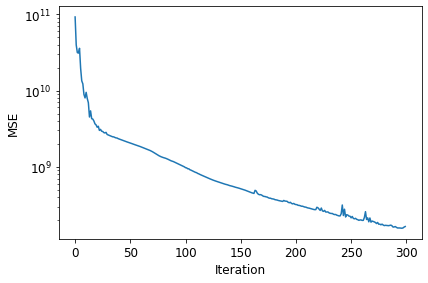

In [214]:
fig, axs = plt.subplots(1, figsize = (6,4))
axs.plot(range(rep_his.shape[0]),rep_his)
axs.set_yscale('log')
axs.set_ylabel('MSE', fontsize=12)
axs.set_xlabel('Iteration', fontsize=12)
plt.tight_layout()
plt.setp(axs.get_yticklabels(), fontsize=12)
plt.setp(axs.get_xticklabels(), fontsize=12)
plt.show()

In [101]:
import seaborn as sns

In [165]:
len(outputs_Qin_test)

301

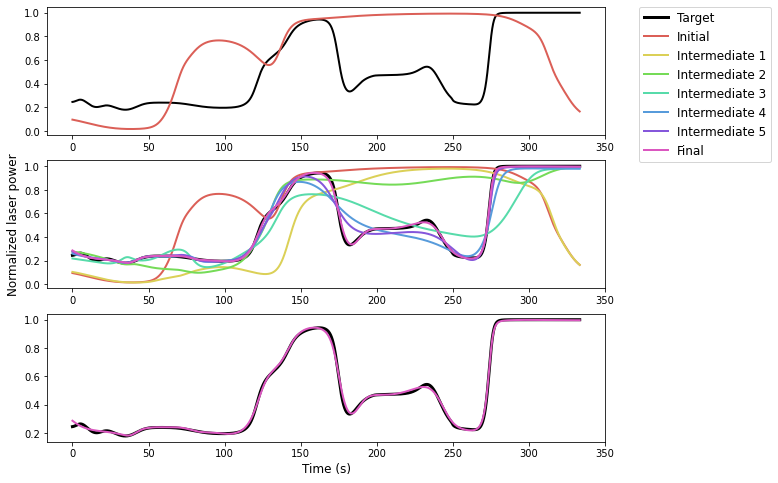

In [232]:
fig, axs = plt.subplots(3,1, figsize = (10,8))
cmap = sns.color_palette("hls", 7)

axs[0].plot(np.arange(0.0, endTime, dt),target_q_np, 'k', linewidth=2, label='Target')
axs[0].plot(np.arange(0.0, endTime, dt), outputs_Qin_test[0], linewidth=2,c=cmap[0],linestyle='-', label='Initial')

axs[1].plot(np.arange(0.0, endTime, dt),target_q_np, 'k', linewidth=3, label='Target')
# axs.plot(np.arange(0.0, endTime, dt), outputs_Qin_test[0], linewidth=2,c='b',linestyle='-', label='Initial')
# axs.plot(np.arange(0.0, endTime, dt), outputs_Qin_test[10], linewidth=2,c='C0', linestyle='-',label='Intermediate 1')
# axs.plot(np.arange(0.0, endTime, dt), outputs_Qin_test[100], linewidth=2,c='g',linestyle='-', label='Intermediate 2')
# axs.plot(np.arange(0.0, endTime, dt), outputs_Qin_test[300], linewidth=2,c='lawngreen',linestyle='-', label='Final')

axs[1].plot(np.arange(0.0, endTime, dt), outputs_Qin_test[0], linewidth=2,c=cmap[0],linestyle='-', label='Initial')
axs[1].plot(np.arange(0.0, endTime, dt), outputs_Qin_test[1], linewidth=2,c=cmap[1], linestyle='-',label='Intermediate 1')
axs[1].plot(np.arange(0.0, endTime, dt), outputs_Qin_test[5], linewidth=2,c=cmap[2],linestyle='-', label='Intermediate 2')
axs[1].plot(np.arange(0.0, endTime, dt), outputs_Qin_test[10], linewidth=2,c=cmap[3],linestyle='-', label='Intermediate 3')
axs[1].plot(np.arange(0.0, endTime, dt), outputs_Qin_test[50], linewidth=2,c=cmap[4], linestyle='-',label='Intermediate 4')
axs[1].plot(np.arange(0.0, endTime, dt), outputs_Qin_test[100], linewidth=2,c=cmap[5],linestyle='-', label='Intermediate 5')
axs[1].plot(np.arange(0.0, endTime, dt), outputs_Qin_test[300], linewidth=2,c=cmap[6],linestyle='-', label='Final')

axs[2].plot(np.arange(0.0, endTime, dt),target_q_np, 'k', linewidth=3, label='Target')
axs[2].plot(np.arange(0.0, endTime, dt), outputs_Qin_test[300], linewidth=2,c=cmap[6],linestyle='-', label='Final')

axs[1].legend(fontsize=12, bbox_to_anchor=(1.05, 2.25), loc='upper left')
# axs[0].set_ylabel('Normalized laser power', fontsize=12)
axs[1].set_ylabel('Normalized laser power', fontsize=12)
# axs[2].set_ylabel('Normalized laser power', fontsize=12)

axs[2].set_xlabel('Time (s)', fontsize=12)
# plt.tight_layout()
# plt.setp(axs.get_yticklabels(), fontsize=12)
# plt.setp(axs.get_xticklabels(), fontsize=12)
plt.show()